In [5]:
# 데이터 불러오기
import pandas as pd
import requests
import numpy as np

import koreanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "./data/202512_202512_연령별인구현황_월간.csv",
    encoding="cp949"
)

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

# 3. 시/군 단위만 추출
# - 시도: code % 100_000_000 == 0
# - 시군구: code % 100_000_000 != 0 AND code % 100_000 == 0
sigungu = df[
    (df["행정코드"] % 100_000_000 != 0) &
    (df["행정코드"] % 100_000 == 0)
].copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2025년12월_계_총인구수",
    "2025년12월_계_20~24세",
    "2025년12월_계_25~29세",
    "2025년12월_계_30~34세",
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 5. 청년(20~34) 인구 계산
sigungu["청년(20~34)인구"] = (
    sigungu["2025년12월_계_20~24세"]
    + sigungu["2025년12월_계_25~29세"]
    + sigungu["2025년12월_계_30~34세"]
)

sigungu["청년비율(20~34)"] = (
    sigungu["청년(20~34)인구"]
    / sigungu["2025년12월_계_총인구수"]
)

# 6. 제외할 광역 단위 정의
exclude_regions = [
    "서울특별시", "경기도", 
    "인천광역시", "광주광역시", "울산광역시",
    "부산광역시", "대구광역시", "대전광역시"
]

sigungu["상위지역"] = sigungu["지역명"].str.split().str[0]

local_sigungu = sigungu[
    ~sigungu["상위지역"].isin(exclude_regions) & (sigungu["지역명"].str.split().str.len() == 2)
].copy()

# 7. 결과 테이블 구성
result = local_sigungu[
    ["지역명", "2025년12월_계_총인구수", "청년(20~34)인구", "청년비율(20~34)"]
].rename(columns={"2025년12월_계_총인구수": "총인구"})

result["청년비율(20~34)"] = (result["청년비율(20~34)"] * 100).round(2)



In [32]:
# 데이터 불러오기
import pandas as pd
import re 

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "../../data/202601_202601_주민등록인구및세대현황_월간.csv",
    encoding="cp949"
)

# 6. 제외할 광역 단위 정의
exclude_regions = [
    "4700000000",   # 경상북도
    "4800000000",   # 경상남도
    "4600000000",   # 전라남도
    "5200000000",   # 전북특별자치도
    "4300000000",   # 충청북도
    "4400000000",   # 충청남도
    "5100000000",   # 강원특별자치도
    "5000000000"    # 제주특별자치도
]

exclude_regions2 = [
    "41",   # 서울특별시 
    "11",   # 경기도
    "26",   # 부산광역시
    "28",   # 인천광역시
    "27",   # 대구광역시 
    "30",   # 대전광역시
    "29",   # 광주광역시
    "31",   # 울산광역시
]

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype(str)

sigungu = df.copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2026년01월_총인구수"
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 1) exclude_regions에 정확히 포함되는 코드 제외
m1 = sigungu["행정코드"].isin(exclude_regions)

# 2) exclude_regions2로 시작하는 코드 중에서,
#    prefix 뒤가 전부 0인 형태(prefix + 0+)는 "포함" 예외
prefix_pat = r"^(?:" + "|".join(map(re.escape, exclude_regions2)) + r")"
m2_starts = sigungu["행정코드"].str.match(prefix_pat)

m2_all_zero_after = sigungu["행정코드"].str.match(prefix_pat + r"0+$")
m2_exclude = m2_starts & ~m2_all_zero_after   # 시작은 하는데, 뒤가 전부 0은 아니면 제외

# 최종: 제외 대상(m1 또는 m2_exclude)을 빼고 남김
sigungu = sigungu[~(m1 | m2_exclude)].copy()

# 7. 결과 테이블 구성
result = sigungu[
    ["지역명", "2026년01월_총인구수"]
].rename(columns={"2026년01월_총인구수": "총인구"})

city_result = result.sort_values("총인구", ascending=False).head(8)

# # 수도권 + 광역시 숫자
city_count = city_result["총인구"].sum()

# result["총인구"].head(8)

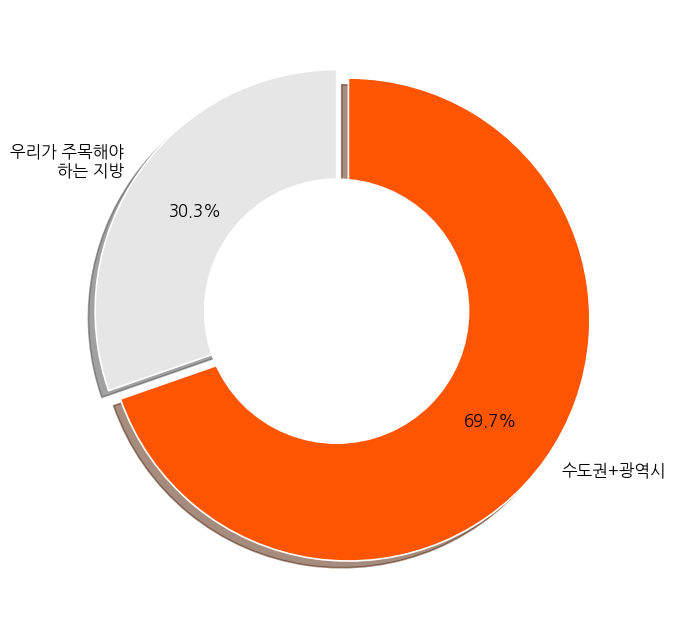

In [41]:
import matplotlib.pyplot as plt

TOTAL_POP = 51_111_158
metro_pop = int(city_count)
other_pop = TOTAL_POP - metro_pop

labels = ["수도권+광역시", "우리가 주목해야\n하는 지방"]
sizes  = [metro_pop, other_pop]
colors = ["#FD5502", "#E6E6E6"]

explode = (0.06, 0.0)  # 포인트 조각만 살짝 분리

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    explode=explode,
    startangle=90,
    counterclock=False,
    shadow=True,  # 입체 느낌 핵심
    autopct=lambda p: f"{p:.1f}%",
    pctdistance=0.72,
    labeldistance=1.08,
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"},
    textprops={"fontsize": 12}
)

# 도넛 구멍 (도넛이 더 세련되고 퍼센트도 잘 읽힘)
centre_circle = plt.Circle((0, 0), 0.55, fc="white")
ax.add_artist(centre_circle)

# ax.set_title("전국 인구 대비 서울+경기+광역시 집중도 (2026년 01월)", fontsize=14)
# ax.text(0, 0.05, f"{metro_pop/TOTAL_POP*100:.1f}%", ha="center", va="center", fontsize=22)
# ax.text(0, -0.12, "서울+경기+광역시", ha="center", va="center", fontsize=11, color="#666666")

plt.tight_layout()
plt.show()


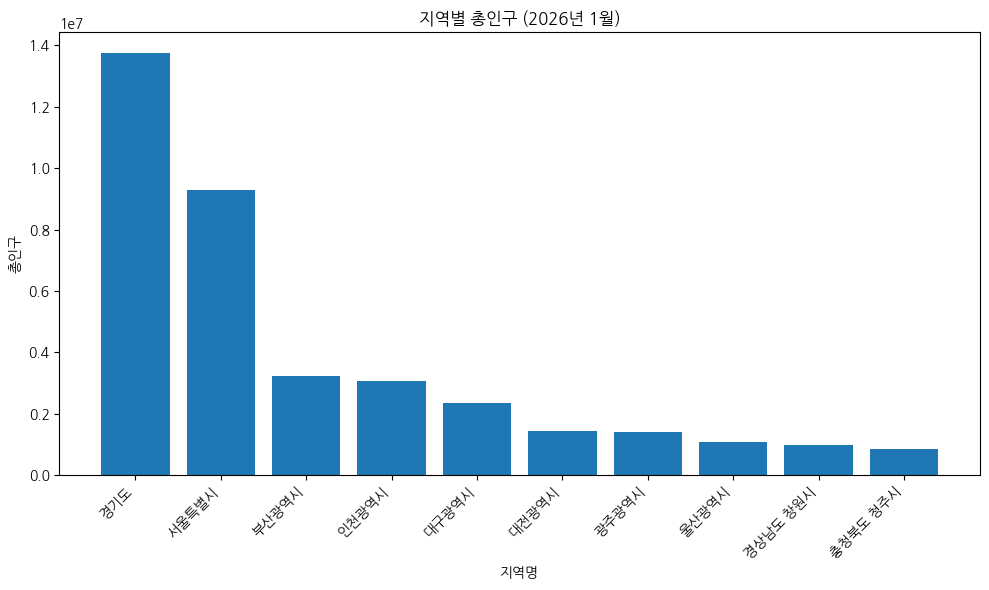

In [ ]:
import matplotlib.pyplot as plt

# 상위 10개 지역
top10 = result.sort_values("총인구", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10["지역명"], top10["총인구"])
plt.xticks(rotation=45, ha="right")
plt.title("지역별 총인구 (2026년 1월)")
plt.ylabel("총인구")
plt.xlabel("지역명")

plt.tight_layout()
plt.show()